In [169]:
import matplotlib.pyplot as plt
from PIL import Image


In [170]:
train_dir=r'''C:\Users\Nandit\Desktop\BDRW_train\BDRW_train_1'''
name=r'''/digit_0.jpg'''


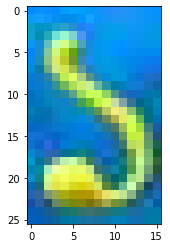

In [171]:
Input=train_dir+name
img=Image.open(Input)
plt.imshow(img)
plt.show()

In [172]:
import pandas as pd
path=r'''C:\Users\Nandit\Desktop\BDRW_train\BDRW_train_1\labels.xls'''
data=pd.read_excel(path, header=None)
data.head()

,0,1
0,digit_0,1
1,digit_1,4
2,digit_2,2
3,digit_3,3
4,digit_4,1


In [173]:
data.rename(columns={ 0:'filename', 1:'class'}, inplace=True)

In [174]:
data.head()

,filename,class
0,digit_0,1
1,digit_1,4
2,digit_2,2
3,digit_3,3
4,digit_4,1


In [175]:
print('File name:', data.iloc[0, 0])

File name: digit_0


In [176]:
print('Class:', data.iloc[0, 1])

Class: 1


In [177]:
print('The number of rows: ', data.shape[0])

The number of rows:  1393


In [178]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
#For installing torchvision :-pip install https://files.pythonhosted.org/packages/8c/52/33d739bcc547f22c522def535a8da7e6e5a0f6b98594717f519b5cb1a4e1/torchvision-0.1.8-py2.py3-none-any.whl


In [179]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, excel_file, data_dir, transform=None):
        
        # Image directory
        self.data_dir=data_dir
        
        # The transform is goint to be used on image
        self.transform = transform
        
        # Load the CSV file contians image info
        self.data_name= data
        
        # Number of images in dataset
        self.len=self.data_name.shape[0] 
    
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        # Image file path
        img_name=self.data_dir + self.data_name.iloc[idx, 0]+".jpg"
        
        # Open image file
        image = Image.open(img_name)
        
        # The class label for the image
        y = self.data_name.iloc[idx, 1]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [180]:
train_dataset = Dataset(excel_file=data
                        , data_dir=r'''C:\Users\Nandit\Desktop\BDRW_train\BDRW_train_1/''')

4


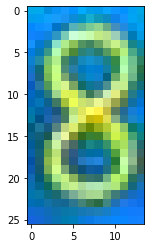

In [181]:
image, y = train_dataset.__getitem__(1)
plt.imshow(image)
print(y)

In [211]:
# Create the transform compose

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.RandomGrayscale(p=0.1), transforms.Scale((224, 224)),
                               transforms.ToTensor(), transforms.Normalize(mean, std)]) #transforms.Resize not working

AttributeError: module 'torchvision.transforms' has no attribute 'RandomGrayscale'

In [206]:
train_dataset = Dataset(excel_file=data
                        , data_dir=r'''C:\Users\Nandit\Desktop\BDRW_train\BDRW_train_1/'''
                        , transform = composed)

In [192]:
validation_data_dir=r'''C:\Users\Nandit\Desktop\BDRW_train\BDRW_val/'''
validation_dataset = Dataset(transform=composed
                          ,excel_file=data
                          ,data_dir=validation_data_dir)


In [200]:
#pytorch modules
import torchvision.models as models
import torch.nn as nn
import torch
#non-pytorch modules
import time
from imageio import imread
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
from matplotlib.pyplot import imshow
torch.manual_seed(0)

In [198]:
#step 1:Load pretrained model resnet18
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Nandit/.cache\torch\checkpoints\resnet18-5c106cde.pth
100.0%


In [201]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [202]:
data["class"].unique()

array([1, 4, 2, 3, 5, 6, 7, 8, 9, 0], dtype=int64)

In [203]:
# Step 3: Re-defined the last layer
model.fc=nn.Linear(512,10)

In [204]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [205]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

In [207]:
# Step 2: Create the data loader
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=15)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=10)

In [208]:
# Step 3: Use the pre-defined optimizer Adam with learning rate 0.003
optimizer=torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.003)


In [209]:
# Step 4: Train the model

N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)
for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x,y in train_loader:
        model.train()
        optimizer.zero_grad()
        z=model(x)
        loss=criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
        loss_list.append(np.mean(loss_sublist))
        
        correct=0
        for x_test,y_test in validation_loader:
            model.eval()
            z=model(x_test)
            _,yhat=torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
            accuracy = correct/n_test
            accuracy_list.append(accuracy)


TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

AttributeError: module 'torchvision' has no attribute '__version__'